In [10]:
#Import necessary Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
#Load the data
quality = pd.read_csv("quality.csv")
quality_data = np.array(quality)

In [12]:
#Split the training-testing sets
X = quality_data[:,1:-1]
y = quality_data[:,-1]
y = y.astype('int')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 88)

In [13]:
print(X_train.shape)
print(X_test.shape)

(98, 12)
(33, 12)


In [14]:
model1 = linear_model.LogisticRegression()
Xlr_train = np.hstack((X_train[:,3].reshape(98, 1),X_train[:,4].reshape(98, 1)))
Xlr_test = np.hstack((X_test[:,3].reshape(33, 1),X_test[:,4].reshape(33, 1)))

model1.fit(Xlr_train,y_train.astype('int'))
print('Coefficient: ', model1.coef_)
print('Intercept: ', model1.intercept_)

ylr_pred = model1.predict(Xlr_test)
ylr_pred_prob =  model1.predict_proba(Xlr_test)

Coefficient:  [[ 0.11055466 -0.00233877]]
Intercept:  [-0.6807395]


C:\Users\rz26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
#Load confusion matrix
from sklearn.metrics import confusion_matrix

CM_lr = confusion_matrix(y_test, ylr_pred)
print(CM_lr)

[[24  0]
 [ 6  3]]


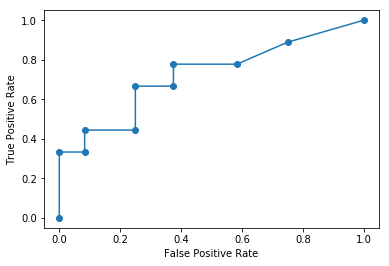

0.7222222222222222

In [16]:
#Calculate out-of-sample AUC
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(y_test.astype('int'), ylr_pred_prob[:,1])
#Draw the ROC curve
plt.plot(fpr,tpr,marker = 'o')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
auc(fpr, tpr)

In [17]:
#Normalize the OfficeVisits and Narcotics as covariates in KNN
OfficeVisits_train = ((X_train[:,3] - np.mean(X_train[:,3]))/np.std(X_train[:,3])).reshape(-1,1)
Narcotics_train = ((X_train[:,3] - np.mean(X_train[:,3]))/np.std(X_train[:,3])).reshape(-1,1)
OfficeVisits_test = ((X_test[:,3] - np.mean(X_test[:,3]))/np.std(X_test[:,3])).reshape(-1,1)
Narcotics_test = ((X_test[:,3] - np.mean(X_test[:,3]))/np.std(X_test[:,3])).reshape(-1,1)


In [18]:
#Build the covariates of training and testing sets
X1_train = np.hstack((OfficeVisits_train,Narcotics_train))
X1_test = np.hstack((OfficeVisits_test,Narcotics_test))

In [19]:
print(X1_train.shape)
print(X1_test.shape)

(98, 2)
(33, 2)


In [20]:
#### Train the knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(X1_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [21]:
#Calculate the overall accuracy of knn model
OA_knn = knn.score(X1_test, y_test) 
print(OA_knn)

0.8181818181818182


In [22]:
#Confusion Matrix
y_pred = knn.predict(X1_test)

CM_knn = confusion_matrix(y_test, y_pred)
print(CM_knn)

[[24  0]
 [ 6  3]]


In [23]:
##Train-Validate-Test Triplet for the healthcare quality case
X1_trainval = X1_train
y_trainval = y_train

#Split the training and validation set
X1_train, X1_val, y_train, y_val = train_test_split(X1_trainval, y_trainval,test_size=0.33)

#Find out which model has the highest validation accuracy
val_scores = []
neighbors = np.arange(1, 15, 2)
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X1_train, y_train)
    val_scores.append(knn.score(X1_val, y_val))
    
print("Best validation accuracy: {:.3f}".format(np.max(val_scores)))
best_n_neighbors = neighbors[np.argmax(val_scores)]
print("Best number of neighbors: {}".format(best_n_neighbors))
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)

#Test the performance of the "best" on the testing set 
knn.fit(X1_trainval, y_trainval)
print("Test-set accuracy: {:.3f}".format(knn.score(X1_test, y_test)))

Best validation accuracy: 0.848
Best number of neighbors: 3
Test-set accuracy: 0.818


In [24]:
##k-fold Cross Validation for healthcare quality case

#import the CV package
from sklearn.model_selection import cross_val_score

#Cross Validation with number of folds k=3
cross_val_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X1_trainval, y_trainval, cv=6)
    cross_val_scores.append(np.mean(scores))
    
    
print("Best cross-validation accuracy: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print("Best number of neighbors: {}".format(best_n_neighbors))
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X1_trainval, y_trainval)
print("Test-set score: {:.3f}".format(knn.score(X1_test, y_test)))

Best cross-validation accuracy: 0.838
Best number of neighbors: 3
Test-set score: 0.818


In [25]:
y_test

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [26]:
##Lasso and Ridge Regression

#Load the boston housing data set
from sklearn.datasets import load_boston
boston = load_boston()

In [27]:
Xb = boston.data 

In [28]:
yb = boston.target

In [29]:
lasso_b = linear_model.Lasso(alpha=1)

In [31]:
lasso_b.fit(Xb,yb)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
print(lasso_b.coef_)

[-0.06343729  0.04916467 -0.          0.         -0.          0.9498107
  0.02090951 -0.66879     0.26420643 -0.01521159 -0.72296636  0.00824703
 -0.76111454]


In [35]:
ridge_b = linear_model.Ridge(alpha=1)
ridge_b.fit(Xb,yb)
print(ridge_b.coef_)

[-1.04595278e-01  4.74432243e-02 -8.80467889e-03  2.55239322e+00
 -1.07770146e+01  3.85400020e+00 -5.41453810e-03 -1.37265353e+00
  2.90141589e-01 -1.29116463e-02 -8.76074394e-01  9.67327945e-03
 -5.33343225e-01]


In [37]:
linear_b = linear_model.LinearRegression()
linear_b.fit(Xb,yb)
print(linear_b.coef_)

[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01]


In [38]:
#Tuning the parameter alpha for lasso and ridge regressions

#Import necessary package
from sklearn.model_selection import GridSearchCV


param_grid = {'alpha': np.logspace(-3, 0, 13)}
print(param_grid)

{'alpha': array([0.001     , 0.00177828, 0.00316228, 0.00562341, 0.01      ,
       0.01778279, 0.03162278, 0.05623413, 0.1       , 0.17782794,
       0.31622777, 0.56234133, 1.        ])}


In [46]:
grid_lasso = GridSearchCV(linear_model.Lasso(), param_grid, cv=10)
grid_lasso.fit(Xb, yb)
print(grid_lasso.best_params_)
print('Best R squared in Lasso Regression: %.2f' %grid_lasso.best_score_)

{'alpha': 0.31622776601683794}
Best R squared in Lasso Regression: 0.28


C:\Users\rz26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
grid_ridge = GridSearchCV(linear_model.Ridge(), param_grid, cv=10)
grid_ridge.fit(Xb, yb)
print(grid_ridge.best_params_)
print('Best R squared in Ridge Regression: %.2f' %grid_ridge.best_score_)

{'alpha': 1.0}
Best R squared in Ridge Regression: 0.26


C:\Users\rz26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
